In [1]:
# exercise 5.1.1
from dtuimldmtools import (
    draw_neural_net,
    train_neural_net,
)
import pandas as pd
from scipy.stats import zscore

url = "https://hastie.su.domains/ElemStatLearn/datasets/SAheart.data"

# Load the SAheart dataset
df = pd.read_csv(url, index_col='row.names')


# Convert binary text data to numbered categories
df['famhist'] = pd.Categorical(df['famhist']).codes

y = df['typea'].to_numpy().reshape(-1, 1)

# Drop the typea column, as that is what we try to predict
df = df.drop("typea", axis=1)

X = df.to_numpy()

# Attribute names
attributeNames = list(map(lambda x: x.capitalize(), df.columns.tolist()))

N, M = X.shape
classNames = [0, 1]
C = len(classNames)

X = zscore(X, ddof=1)  # Mean = 0, Std = 1
y = zscore(y, ddof=1)  # Mean = 0, Std = 1

# Step 2: Normalization (Min-Max Scaling to [0,1])
# X = (X_standardized - X_standardized.min()) / (X_standardized.max() - X_standardized.min())
# y = (y_standardized - y_standardized.min()) / (y_standardized.max() - y_standardized.min())

[Sequential(
   (0): Linear(in_features=9, out_features=1, bias=True)
   (1): Tanh()
   (2): Linear(in_features=1, out_features=1, bias=True)
 )
 Sequential(
   (0): Linear(in_features=9, out_features=2, bias=True)
   (1): Tanh()
   (2): Linear(in_features=2, out_features=1, bias=True)
 )
 Sequential(
   (0): Linear(in_features=9, out_features=3, bias=True)
   (1): Tanh()
   (2): Linear(in_features=3, out_features=1, bias=True)
 )
 Sequential(
   (0): Linear(in_features=9, out_features=4, bias=True)
   (1): Tanh()
   (2): Linear(in_features=4, out_features=1, bias=True)
 )
 Sequential(
   (0): Linear(in_features=9, out_features=5, bias=True)
   (1): Tanh()
   (2): Linear(in_features=5, out_features=1, bias=True)
 )
 Sequential(
   (0): Linear(in_features=9, out_features=6, bias=True)
   (1): Tanh()
   (2): Linear(in_features=6, out_features=1, bias=True)
 )
 Sequential(
   (0): Linear(in_features=9, out_features=7, bias=True)
   (1): Tanh()
   (2): Linear(in_features=7, out_features=1,

0it [00:00, ?it/s]/Users/kostyalbalint/Documents/Egyetem/MSC/1.st Semester/IntroductionToMachineLearning/Intro-to-MI-Project_1/.venv/lib/python3.13/site-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([415])) that is different to the input size (torch.Size([415, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/kostyalbalint/Documents/Egyetem/MSC/1.st Semester/IntroductionToMachineLearning/Intro-to-MI-Project_1/ann_validate.py:241: RuntimeWarning: overflow encountered in cast
  if loss_value < best_final_loss:
2it [00:13,  6.91s/it]/Users/kostyalbalint/Documents/Egyetem/MSC/1.st Semester/IntroductionToMachineLearning/Intro-to-MI-Project_1/.venv/lib/python3.13/site-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([416])) that is different to the input size (torch.Size([416, 1])). This will li

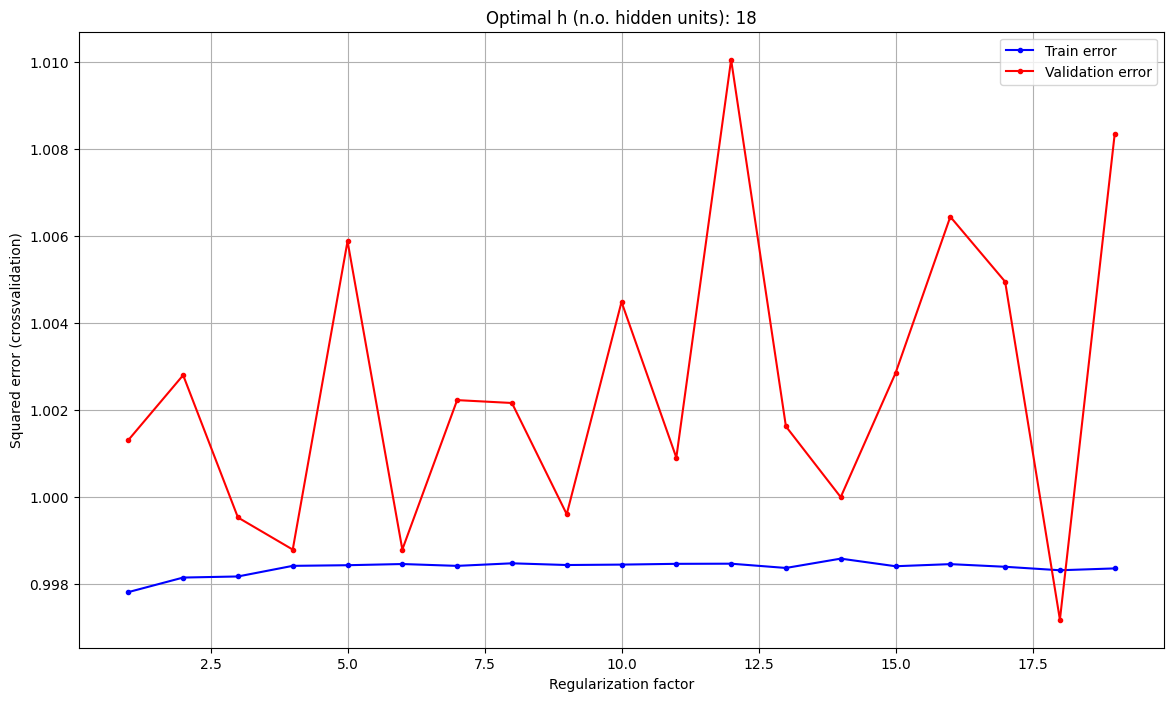

ANN results
- Training error: 0.9983195245265961
- Test error:     0.9971819043159484


In [2]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import model_selection
import torch
from ann_validate import ann_validate
from dtuimldmtools import rlr_validate

## Crossvalidation
# Create crossvalidation partition for evaluation
K = 10
n_replicates = 1  # number of networks trained in each k-fold
max_iter = 10000
CV = model_selection.KFold(K, shuffle=True)
# CV = model_selection.KFold(K, shuffle=False)

n_hidden_units_range = range(1, 20)

# Initialize variables
# T = len(lambdas)
Error_train_rlr = np.empty((K, 1))
Error_test_rlr = np.empty((K, 1))
Error_train_nofeatures = np.empty((K, 1))
Error_test_nofeatures = np.empty((K, 1))
w_rlr = np.empty((M, K))
mu = np.empty((K, M - 1))
sigma = np.empty((K, M - 1))
w_noreg = np.empty((M, K))


#for train_index, test_index in CV.split(X, y):
    # Extract training and test set for current CV fold, convert to tensors
    #X_train = torch.Tensor(X[train_index, :])
    #y_train = torch.Tensor(y[train_index])
    #X_test = torch.Tensor(X[test_index, :])
    #y_test = torch.Tensor(y[test_index])

loss_fn = torch.nn.MSELoss()
models = np.empty((len(n_hidden_units_range),), dtype=object)

CV = model_selection.KFold(K, shuffle=True)

# Generate out models with different number of hidden units
for i, n_hidden_units in enumerate(n_hidden_units_range):
    model = torch.nn.Sequential(
        torch.nn.Linear(M, n_hidden_units),  # Input layer
        torch.nn.Tanh(),  # Hidden activation (ReLU is also good)
        torch.nn.Linear(n_hidden_units, 1)   # Output layer (NO SIGMOID for regression)
    )
    models[i] = model

(
    opt_val_err,
    opt_model_index,
    opt_model,
    opt_network,
    train_err_vs_lambda,
    test_err_vs_lambda
    #This does a folding cross-validation
) = ann_validate(X, y, models, loss_fn, n_replicates, max_iter, K, CV)

Error_train = np.square(y-opt_network(torch.Tensor(X)).detach().numpy()).sum()/y.shape[0]
Error_test = np.square(y-opt_network(torch.Tensor(X)).detach().numpy()).sum()/y.shape[0]

# Display the results for the last cross-validation fold
plt.figure(1, figsize=(14, 8))
plt.title("Optimal h (n.o. hidden units): {0}".format(n_hidden_units_range[opt_model_index]))
plt.plot(
    n_hidden_units_range, train_err_vs_lambda.T, "b.-", n_hidden_units_range, test_err_vs_lambda.T, "r.-"
)
plt.xlabel("Regularization factor")
plt.ylabel("Squared error (crossvalidation)")
plt.legend(["Train error", "Validation error"])
plt.grid()


plt.savefig('regression_lambda.png')
plt.show()
# Display results

print("ANN results")
print("- Training error: {0}".format(train_err_vs_lambda[opt_model_index]))
print("- Test error:     {0}".format(test_err_vs_lambda[opt_model_index]))


Training model of type:

Sequential(
  (0): Linear(in_features=9, out_features=19, bias=True)
  (1): Tanh()
  (2): Linear(in_features=19, out_features=1, bias=True)
)


Crossvalidation fold: 1/10

	Replicate: 1/1
		Iter	Loss			Rel. loss
		1000	0.6024252	0.0004787448
		2000	0.39279217	0.00028368455
		3000	0.30959755	0.00017988037
		4000	0.26380545	0.00013035136
		5000	0.23539436	7.019806e-05
		6000	0.22117427	6.669477e-05
		7000	0.20414443	6.167548e-05
		8000	0.1926595	5.3210217e-05
		9000	0.18315817	4.645257e-05
		10000	0.1747597	3.862427e-05
		Final loss:
		10000	0.1747597	3.862427e-05

	Best loss: 0.17475970089435577


Crossvalidation fold: 2/10

	Replicate: 1/1
		Iter	Loss			Rel. loss
		1000	0.66473055	0.00044500042


/Users/kostyalbalint/Documents/Egyetem/MSC/1.st Semester/IntroductionToMachineLearning/Intro-to-MI-Project_1/.venv/lib/python3.13/site-packages/dtuimldmtools/models/nn_trainer.py:141: RuntimeWarning: overflow encountered in cast
  if loss_value < best_final_loss:


		2000	0.4104973	0.00055233
		3000	0.29680988	0.0002390162
		4000	0.23960818	0.00019306174
		5000	0.2131366	8.284083e-05
		6000	0.19333369	0.00010604372
		7000	0.17711212	6.8059824e-05
		8000	0.16734783	4.8882244e-05
		9000	0.1598466	4.5210447e-05
		10000	0.15109055	6.2326515e-05
		Final loss:
		10000	0.15109055	6.2326515e-05

	Best loss: 0.15109054744243622


Crossvalidation fold: 3/10

	Replicate: 1/1
		Iter	Loss			Rel. loss
		1000	0.6346324	0.000469567
		2000	0.381432	0.00044375315
		3000	0.29414576	0.00012379553
		4000	0.25375706	0.00015324133
		5000	0.22808096	8.610118e-05
		6000	0.20962787	7.35664e-05
		7000	0.19269054	0.00010415547
		8000	0.17314988	8.140549e-05
		9000	0.1622157	5.15309e-05
		10000	0.15524736	3.7816008e-05
		Final loss:
		10000	0.15524736	3.7816008e-05

	Best loss: 0.15524736046791077


Crossvalidation fold: 4/10

	Replicate: 1/1
		Iter	Loss			Rel. loss
		1000	0.55935025	0.0005126128
		2000	0.33834317	0.00032342467
		3000	0.26961166	0.00019351451
		4000	0.234217

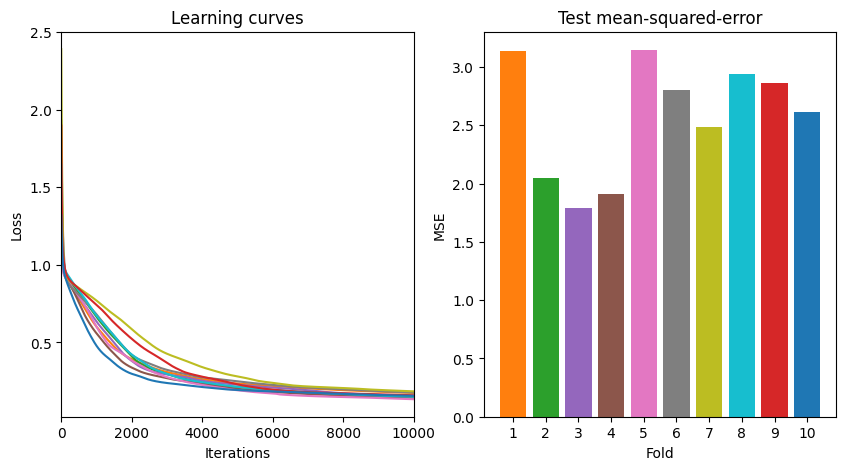

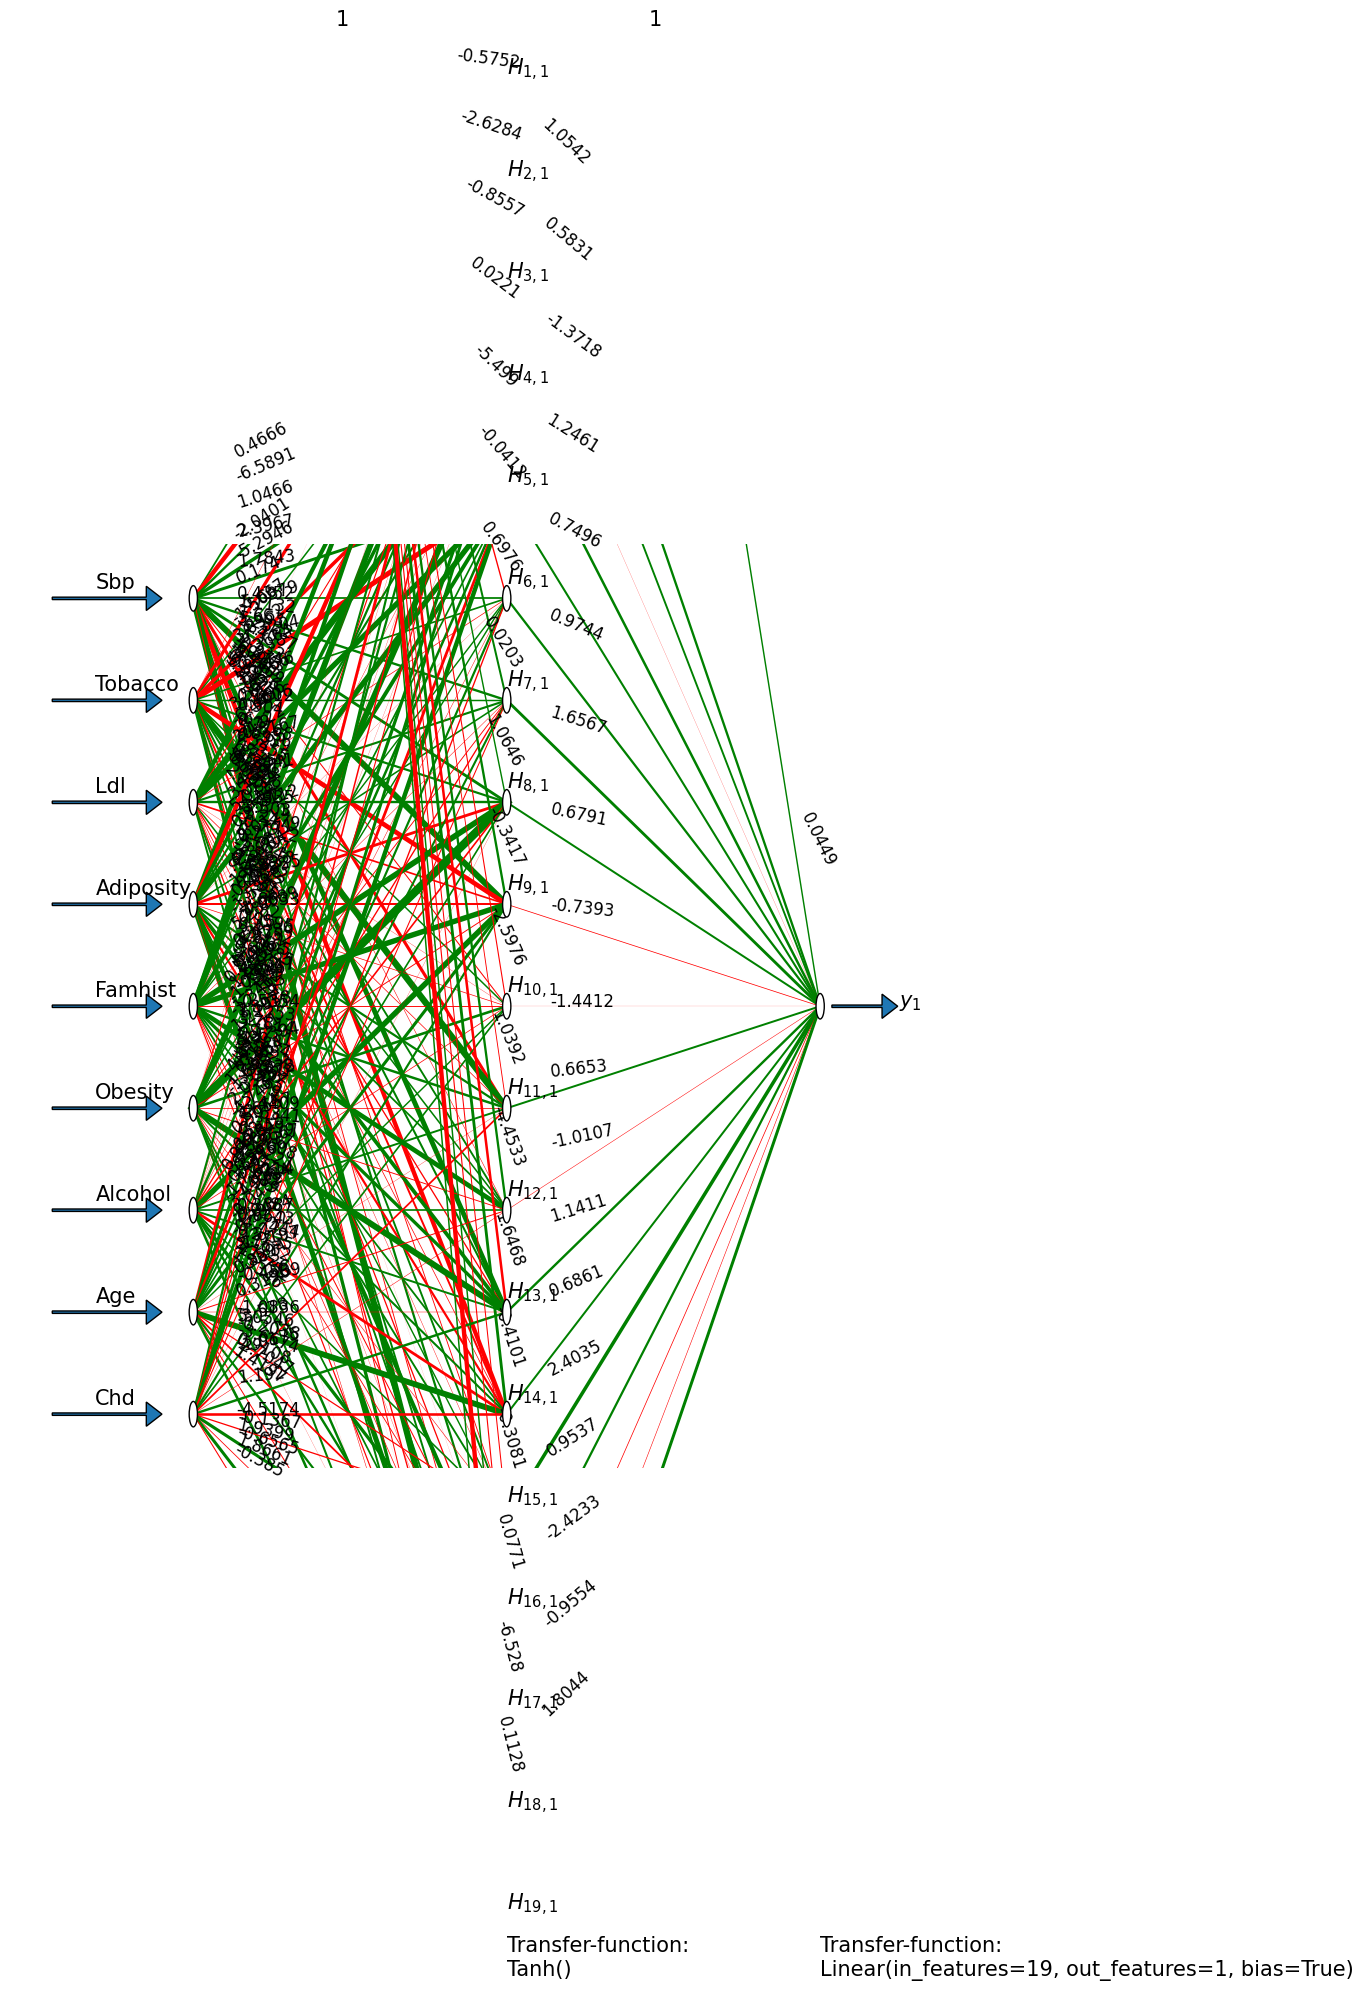


Estimated generalization error, RMSE: 1.6043000221252441


In [3]:
summaries, summaries_axes = plt.subplots(1, 2, figsize=(10, 5))
# Make a list for storing assigned color of learning curve for up to K=10
color_list = [
    "tab:orange",
    "tab:green",
    "tab:purple",
    "tab:brown",
    "tab:pink",
    "tab:gray",
    "tab:olive",
    "tab:cyan",
    "tab:red",
    "tab:blue",
]

model = lambda: torch.nn.Sequential(
    torch.nn.Linear(M, n_hidden_units),  # M features to n_hidden_units
    torch.nn.Tanh(),  # 1st transfer function,
    torch.nn.Linear(n_hidden_units, 1),  # n_hidden_units to 1 output neuron
    # no final tranfer function, i.e. "linear output"
)
loss_fn = torch.nn.MSELoss()  # notice how this is now a mean-squared-error loss

print("Training model of type:\n\n{}\n".format(str(model())))
errors = []  # make a list for storing generalizaition error in each loop
for k, (train_index, test_index) in enumerate(CV.split(X, y)):
    print("\nCrossvalidation fold: {0}/{1}".format(k + 1, K))

    # Extract training and test set for current CV fold, convert to tensors
    X_train = torch.Tensor(X[train_index, :])
    y_train = torch.Tensor(y[train_index])
    X_test = torch.Tensor(X[test_index, :])
    y_test = torch.Tensor(y[test_index])

    # Train the net on training data
    net, final_loss, learning_curve = train_neural_net(
        model,
        loss_fn,
        X=X_train,
        y=y_train,
        n_replicates=n_replicates,
        max_iter=max_iter,
    )

    print("\n\tBest loss: {}\n".format(final_loss))

    # Determine estimated class labels for test set
    y_test_est = net(X_test)

    # Determine errors and errors
    se = (y_test_est.float() - y_test.float()) ** 2  # squared error
    mse = (sum(se).type(torch.float) / len(y_test)).data.numpy()  # mean
    errors.append(mse)  # store error rate for current CV fold

    # Display the learning curve for the best net in the current fold
    (h,) = summaries_axes[0].plot(learning_curve, color=color_list[k])
    h.set_label("CV fold {0}".format(k + 1))
    summaries_axes[0].set_xlabel("Iterations")
    summaries_axes[0].set_xlim((0, max_iter))
    summaries_axes[0].set_ylabel("Loss")
    summaries_axes[0].set_title("Learning curves")

# Display the MSE across folds
summaries_axes[1].bar(
    np.arange(1, K + 1), np.squeeze(np.asarray(errors)), color=color_list
)
summaries_axes[1].set_xlabel("Fold")
summaries_axes[1].set_xticks(np.arange(1, K + 1))
summaries_axes[1].set_ylabel("MSE")
summaries_axes[1].set_title("Test mean-squared-error")

print("Diagram of best neural net in last fold:")
weights = [net[i].weight.data.numpy().T for i in [0, 2]]
biases = [net[i].bias.data.numpy() for i in [0, 2]]
tf = [str(net[i]) for i in [1, 2]]
draw_neural_net(weights, biases, tf, attribute_names=attributeNames)

# Print the average classification error rate
print(
    "\nEstimated generalization error, RMSE: {0}".format(
        round(np.sqrt(np.mean(errors)), 4)
    )
)

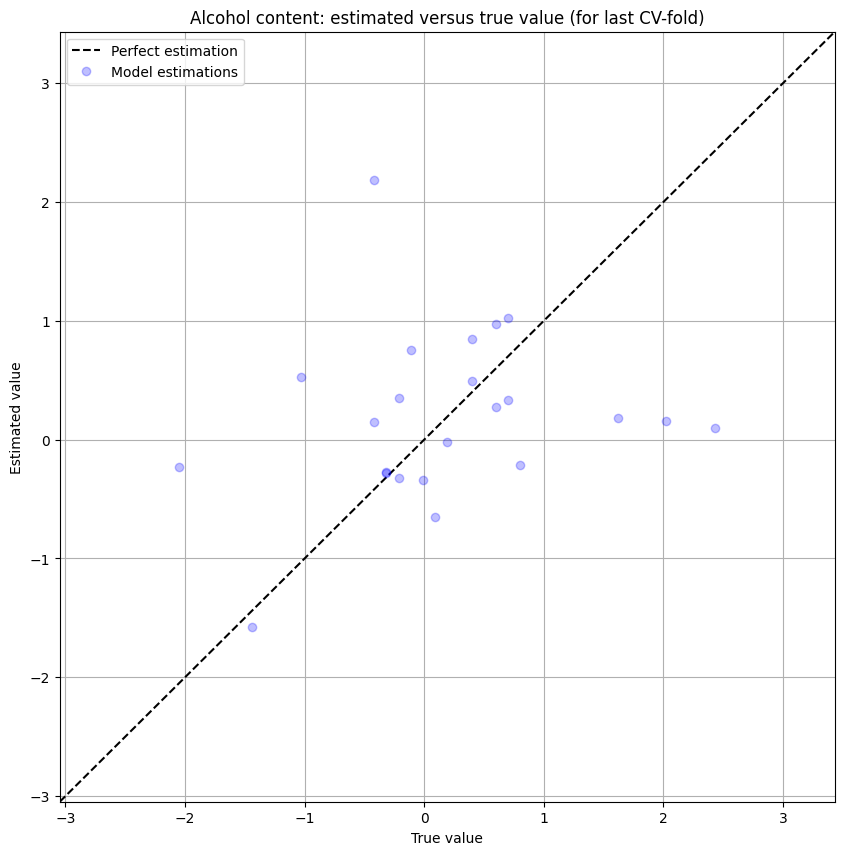

In [222]:
plt.figure(figsize=(10, 10))
y_est = y_test_est.data.numpy()
y_true = y_test.data.numpy()
axis_range = [np.min([y_est, y_true]) - 1, np.max([y_est, y_true]) + 1]
plt.plot(axis_range, axis_range, "k--")
plt.plot(y_true, y_est, "ob", alpha=0.25)
plt.legend(["Perfect estimation", "Model estimations"])
plt.title("Alcohol content: estimated versus true value (for last CV-fold)")
plt.ylim(axis_range)
plt.xlim(axis_range)
plt.xlabel("True value")
plt.ylabel("Estimated value")
plt.grid()

plt.show()

In [223]:
import numpy as np
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error

# Define K-Fold Cross-Validation
K = 5  # Number of folds
kf = KFold(n_splits=K, shuffle=True, random_state=42)

mse_scores = []

# Perform Cross-Validation
for train_index, test_index in kf.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    # Compute the mean of y_train as the baseline prediction
    y_baseline = np.mean(y_train)

    # Predict the same mean value for all test samples
    y_pred_baseline = np.full_like(y_test, y_baseline)

    # Compute and store the MSE
    mse = mean_squared_error(y_test, y_pred_baseline)
    mse_scores.append(mse)



# Compute average MSE across all folds
mean_mse = np.mean(mse_scores)

print(f"Baseline Model - Cross-Validation MSE: {mean_mse:.4f}")


Baseline Model - Cross-Validation MSE: 1.0079
